In [1]:
%pip install pandas matplotlib scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [3]:
N_STARLINK = 'Starlink'
N_SHAW = 'Shaw'

In [4]:
src_dirs = ['data/starlink_ping_2022-04-14/', 'data/trad_ping_2022-04-14/']

In [5]:
from common import combine_csvs

In [49]:
df = pd.DataFrame()
for folder in src_dirs:
    for region in os.scandir(folder):
        pattern = f"{region.path}/*"
        print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), 3)
        df_temp.index = pd.to_datetime(df_temp.index, unit='s')
        df_temp = df_temp.iloc[:,[2]]
        df_temp.rename(columns={df_temp.columns[0]: f"{folder}_{region.name}"}, inplace=True)

        df = df.merge(df_temp, how='outer', left_index=True, right_index=True)



data/starlink_ping_2022-04-14/Sydney/*
data/starlink_ping_2022-04-14/N. California/*
data/trad_ping_2022-04-14/Sydney/*
data/trad_ping_2022-04-14/N. California/*


In [50]:
df.shape[0]

10110

In [51]:
num_regs = int(len(df.columns) / 2) # One for each of Shaw vs Starlink
print(num_regs)
cols = df.columns.tolist()

2


In [52]:
df.head()

,data/starlink_ping_2022-04-14/_Sydney,data/starlink_ping_2022-04-14/_N. California,data/trad_ping_2022-04-14/_Sydney,data/trad_ping_2022-04-14/_N. California
2022-04-13 05:06:07,NaN,57.4,NaN,NaN
2022-04-13 05:06:08,NaN,47.8,NaN,NaN
2022-04-13 05:06:09,NaN,61.9,NaN,NaN
2022-04-13 05:06:10,NaN,52.9,NaN,NaN
2022-04-13 05:06:11,NaN,51.0,NaN,NaN


In [53]:
new_cols = []
for col in cols:
    region = os.path.basename(col).replace('_',' ').strip()
    new_cols.append(region)

#regions = ['Mumbai', 'Sydney', 'Singapore', 
#        'N. California', 'London', 'Bahrain', 'Sao Paulo', 'Tokyo', 'Africa']

multi_cols = [
        [N_SHAW] * num_regs + [N_STARLINK] * num_regs,
        new_cols
        ]
df.set_axis(multi_cols, axis=1, inplace=True)
df

Shaw               Starlink              
                    Sydney N. California   Sydney N. California
2022-04-13 05:06:07    NaN          57.4      NaN           NaN
2022-04-13 05:06:08    NaN          47.8      NaN           NaN
2022-04-13 05:06:09    NaN          61.9      NaN           NaN
2022-04-13 05:06:10    NaN          52.9      NaN           NaN
2022-04-13 05:06:11    NaN          51.0      NaN           NaN
...                    ...           ...      ...           ...
2022-04-15 01:06:24  243.0          63.8      NaN           NaN
2022-04-15 01:06:25  243.0          55.2      NaN           NaN
2022-04-15 01:06:26  263.0          53.8      NaN           NaN
2022-04-15 01:06:27  245.0          49.7      NaN           NaN
2022-04-15 01:06:28  258.0          39.7      NaN           NaN

[10110 rows x 4 columns]

In [73]:
# Filter
df_processed = df.loc['2022-04-14':]
df_processed = df_processed.resample('1S').mean().dropna(how='all')
df_processed

Shaw               Starlink              
                    Sydney N. California   Sydney N. California
2022-04-14 22:20:48    NaN          50.3      NaN           NaN
2022-04-14 22:20:49    NaN          48.8      NaN           NaN
2022-04-14 22:20:50    NaN          54.8      NaN           NaN
2022-04-14 22:20:51    NaN          68.8      NaN           NaN
2022-04-14 22:20:52    NaN          59.8      NaN           NaN
...                    ...           ...      ...           ...
2022-04-15 01:06:24  243.0          63.8      NaN           NaN
2022-04-15 01:06:25  243.0          55.2      NaN           NaN
2022-04-15 01:06:26  263.0          53.8      NaN           NaN
2022-04-15 01:06:27  245.0          49.7      NaN           NaN
2022-04-15 01:06:28  258.0          39.7      NaN           NaN

[9941 rows x 4 columns]

In [54]:
df_processed = df

In [ ]:
df_regs_interp = df.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [74]:
df_unstacked = df_processed.unstack().reset_index(name='latency')
N_REGIONS = 'Regions'
N_TIMESTAMP = 'timestamp'
N_TYPE = 'type'
df_unstacked.dropna(inplace=True)
df_unstacked.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS, 'level_2': N_TIMESTAMP},
        inplace=True)
df_unstacked

,type,Regions,timestamp,latency
18,Shaw,Sydney,2022-04-14 22:21:06,247.0
19,Shaw,Sydney,2022-04-14 22:21:07,245.0
20,Shaw,Sydney,2022-04-14 22:21:08,252.0
21,Shaw,Sydney,2022-04-14 22:21:09,251.0
22,Shaw,Sydney,2022-04-14 22:21:10,258.0
...,...,...,...,...
29806,Starlink,Sydney,2022-04-15 01:06:12,156.0
29807,Starlink,Sydney,2022-04-15 01:06:13,155.0
29808,Starlink,Sydney,2022-04-15 01:06:14,155.0
29809,Starlink,Sydney,2022-04-15 01:06:15,150.0


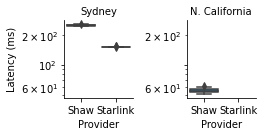

In [67]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

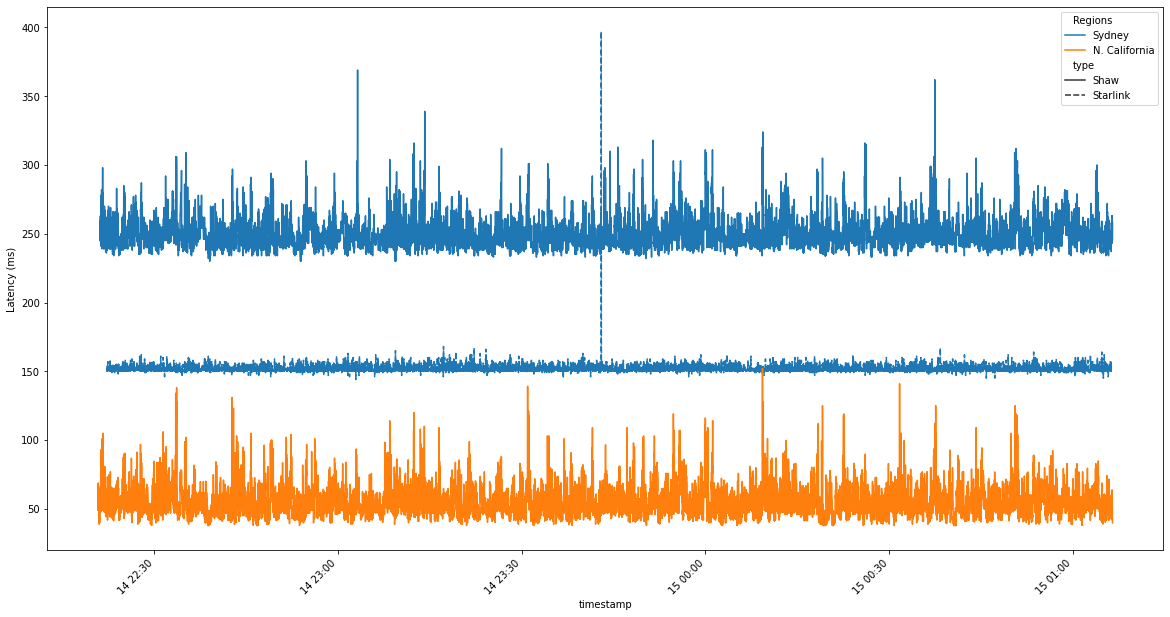

In [75]:
#fig, ax = plt.subplots(figsize=(3.5,2))
fig, ax = plt.subplots(figsize=(20,10))
#ax.xaxis.update_units(df.index)
sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y="latency", hue=N_REGIONS, style=N_TYPE)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
ax.set_ylabel('Latency (ms)')

filename = 'output/out_plot'
plt.savefig(f'{filename}.png', bbox_inches='tight')
plt.show()

In [ ]:
########
#fig, axs = plt.subplots(1, num_regs, figsize=(7.16,5))
#ax_big = fig.add_subplot(111, frameon=False)

#df_regions = []
#for i in range(num_regs):
#    df_region = df.iloc[:,[i,(num_regs+i)]]
#    boxplt = sns.boxplot(x="variable", y="value", data=pd.melt(df_region), ax=axs[i], showfliers=False)

#    raw_region = df_region.columns[0]
#    region = raw_region.split('/')[1].replace('_',' ').strip()
#    boxplt.set(xlabel=region, ylabel=None)

#    #axs[i].set(yscale='log')
#    axs[i].set_xticklabels(labels=["Shaw", "Starlink"], fontsize=9)
#    axs[i].tick_params(labelsize=9)


#ax_big.set_xlabel("Network Provider and Region", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_ylabel("Latency (ms)", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_yticklabels([])
#ax_big.set_xticklabels([])
#ax_big.tick_params(
#    which='both',
#    bottom=False,
#    left=False,
#    right=False,
#    top=False)
#ax_big.grid(False)
#############